# Cognitive Data with Machine Learning

In [1]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import make_machine_learning_df, plot_roc_curve, plot_model_score_results
from utils import plot_train_test_counts, feature_imp, plot_feature_importances

In [2]:
%matplotlib inline 
sns.set() # set seaborn styles, not sure I need to run %matplotlib inline 

In [3]:
# sklearn libraries
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve

---

## models and cognitive scores used
### models used
 - LogisticRegression
 - svm.SVC
 - GaussianNB
 - RandomForestClassifier
 
### score types
- low_global_re
  - Race-adjusted indicator, bottom quartile for z_global_re. 1=low, 0=not low  
- low_cerad_re  
  - Race-adjusted indicator, bottom quartile for z_cerad_re. 1=low, 0=not low
- low_animal_re
  - Race-adjusted indicator, bottom quartile for z_animal_re. 1=low, 0=not low
- low_digit_re
  - Race-adjusted indicator, bottom quartile for z_digit_re. 1=low, 0=not low
- low_delayed_re
  - Race-adjusted indicator, bottom quartile for z_delayed_re. 1=low, 0=not low

In [4]:
models = [LogisticRegression, svm.SVC, GaussianNB, RandomForestClassifier]
scores = ['low_global_re', 'low_cerad_re', 'low_animal_re', 'low_digit_re', 'low_delayed_re']

---

## data prep
create datafarames for deomgraphics, cognitive functioning scrores, and perio info  
NHANES cognitive data downloaded from https://www.icpsr.umich.edu/web/about/cms/3625/

`adjusted_df` is a dataframe with records duplicated according to the survey weight.

In [5]:
adjusted_df = make_machine_learning_df(test_col=scores) # NB: the data is duplicated to reflect surview weights
len(adjusted_df)

['SEQN', 'female', 'ridageyr', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6', 'low_global_re', 'low_cerad_re', 'low_animal_re', 'low_digit_re', 'low_delayed_re']


8554

In [6]:
adjusted_df.head(2)

,female,age,low_cerad_re,low_animal_re,low_digit_re,low_delayed_re,low_global_re,pct_teeth_gt_3,pct_teeth_gt_4,pct_teeth_gt_5,pct_teeth_gt_6
SEQN,,,,,,,,,,,
62174,0,80,0.0,0.0,1.0,0.0,0.0,0.44,0.11,0.0,0.0
62174,0,80,0.0,0.0,1.0,0.0,0.0,0.44,0.11,0.0,0.0


## scale/stanardize data (i.e., z-scores)

In [13]:
# standarize train_df values
scaler = StandardScaler() # creates z-scores

# trainform data
standardize_cols = ['age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6']
scaled_data = scaler.fit_transform(adjusted_df[standardize_cols].to_numpy())

# put scaled data in dataframe
scaled_df = pds.DataFrame(scaled_data, columns=standardize_cols, index=adjusted_df.index)
scaled_df = pds.concat([adjusted_df[['female'] + scores], scaled_df], axis=1)

In [14]:
scaled_df.female.value_counts()

0    5388
1    3166
Name: female, dtype: int64

---

### split train/test
note: `y` is dict with each of the score type values

In [17]:
scaled_df.columns

Index(['female', 'low_global_re', 'low_cerad_re', 'low_animal_re',
       'low_digit_re', 'low_delayed_re', 'age', 'pct_teeth_gt_3',
       'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6'],
      dtype='object')

In [18]:
# scores = ['low_global_re', 'low_cerad_re', 'low_animal_re', 'low_digit_re', 'low_delayed_re']

# train_df = merged_df.dropna()[['z_global_age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6']]
# train_df = train_df.rename(columns={'z_global_age': 'age'})
X = scaled_df.drop(scores, axis=1)
y = {
    score: scaled_df[score].values
    for score in scores
}

In [19]:
X.head()

,female,age,pct_teeth_gt_3,pct_teeth_gt_4,pct_teeth_gt_5,pct_teeth_gt_6
SEQN,,,,,,
62174,0,1.577048,-0.616603,-1.034994,-1.033212,-0.722179
62174,0,1.577048,-0.616603,-1.034994,-1.033212,-0.722179
62174,0,1.577048,-0.616603,-1.034994,-1.033212,-0.722179
62174,0,1.577048,-0.616603,-1.034994,-1.033212,-0.722179
62174,0,1.577048,-0.616603,-1.034994,-1.033212,-0.722179


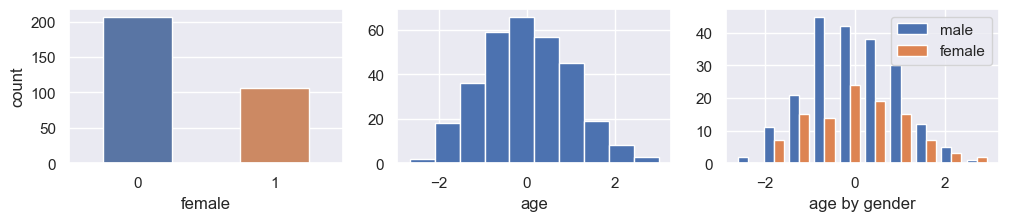

In [57]:
# plt.figure(figsize=(10,2))
fig, axs = plt.subplots(1, 3, figsize=(12,2))

# gender counts
sns.barplot(
    ax=axs[0],
    data=scaled_df.female.value_counts().reset_index().rename(columns={'index': 'female', 'female': 'count'}),
    x='female', 
    y='count',
    width=0.5
)


# total age counts
axs[1].hist(scaled_df[['age']])
axs[1].set_xlabel('age')

# age counts by gender
axs[2].hist(
        [
            scaled_df.loc[scaled_df['female'] == 0, 'age'],
            scaled_df.loc[scaled_df['female'] == 1, 'age']
        ],
        label=['male', 'female']
     )
axs[2].set_xlabel('age by gender')

plt.legend()
# for ax in axs.flat: ax.label_outer() # share y axis
plt.show()

### run each model on each score type 
**starting with the most general `low_global_re`**


---------------------- model results for ** low_global_re **  ----------------------



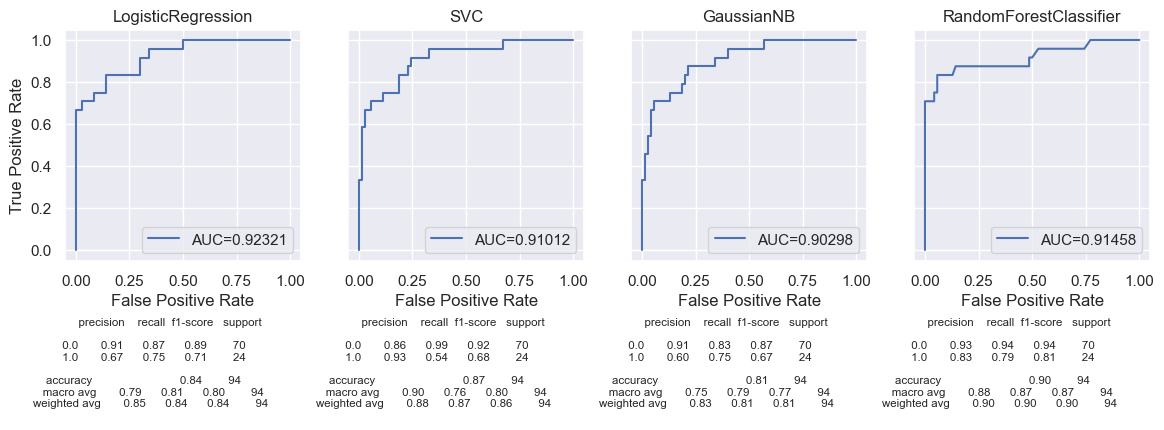


---------------------- model results for ** low_cerad_re **  ----------------------



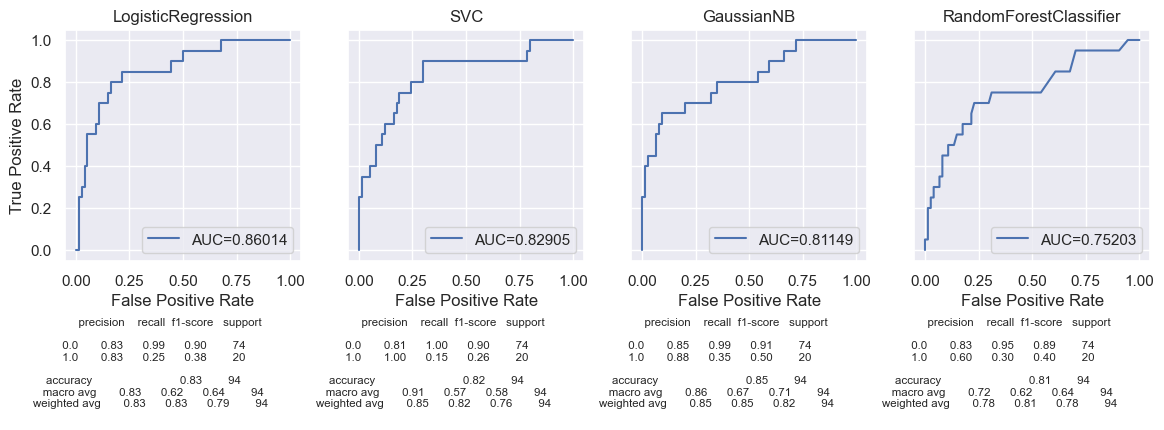


---------------------- model results for ** low_animal_re **  ----------------------



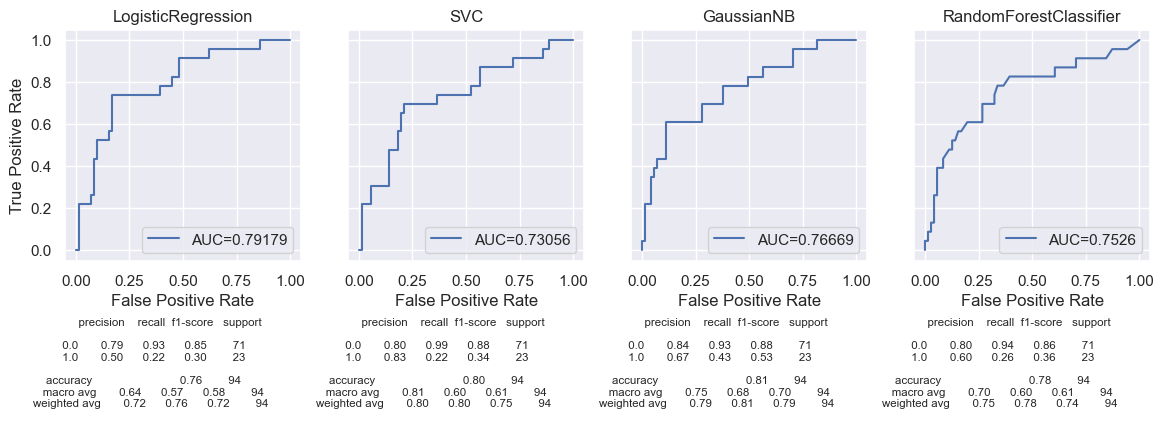


---------------------- model results for ** low_digit_re **  ----------------------



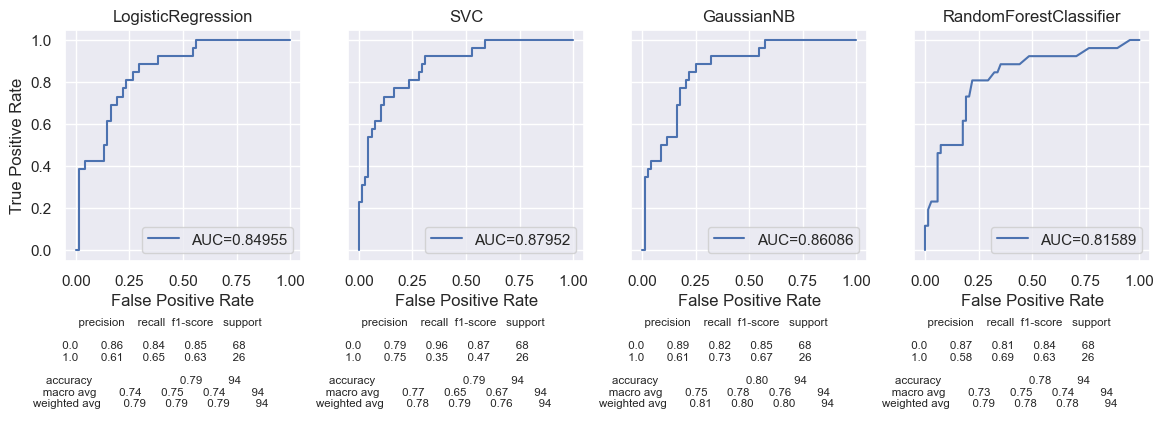


---------------------- model results for ** low_delayed_re **  ----------------------



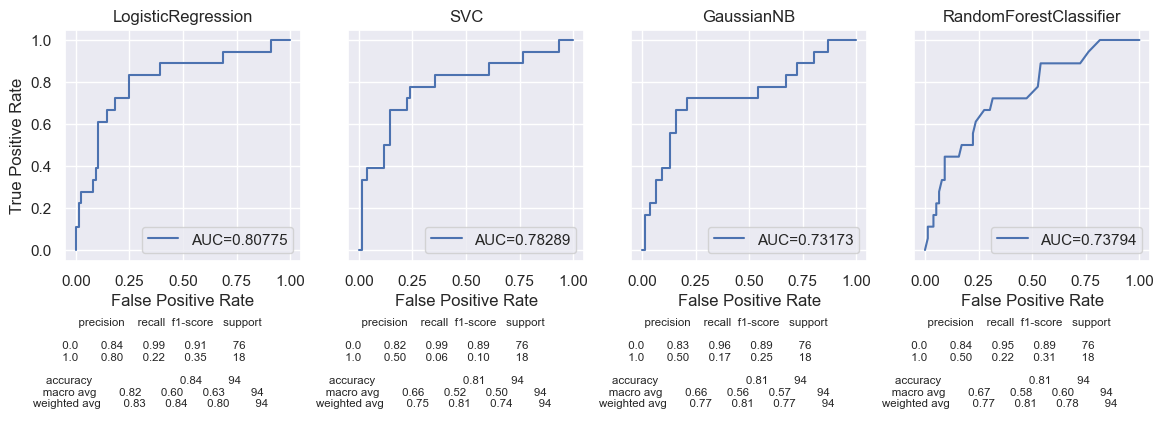

In [58]:
for score in scores:
    score_results = {} # dict to hold results of model predictions for each score
    
    # create test and train datasets
    X_train, X_test, y_train, y_test = \
        train_test_split(
            #train_df.pct_teeth_gt_3.values.reshape(-1, 1), 
            scaled_df,
            y[score], 
            test_size=0.3, 
            random_state=42, 
            stratify=y[score]
        )
    for model in models:
        # special case for svm.SVC
        if model == svm.SVC:
            # you can try differnt kernels for different results (e.g, 'rbr', 'linear', 'sigmoid')
            clf = svm.SVC(kernel='poly', probability=True) 
        else:
            clf = model()
            
        # fit the model and make predictions
        clf.fit(X_train, y_train) 
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[::,1]
        
        # store results        
        model_name = str(model).split('.')[-1][:-2] # parse out name of model
        score_results[model_name] = {}
        score_results[model_name]['y_test'] = y_test
        score_results[model_name]['y_pred'] = y_pred
        score_results[model_name]['y_proba'] = y_proba
        score_results[model_name]['title'] = model_name # just use model name as title

        
    # plot results
    print(f'\n---------------------- model results for ** {score} **  ----------------------\n')
    plot_model_score_results(score_results)
            

---

In [59]:
X_train, X_test, y_train, y_test = \
    train_test_split(train_df.pct_teeth_gt_3.values.reshape(-1, 1), y['low_global_re'], test_size=0.3, random_state=42, stratify=y['low_global_re'])

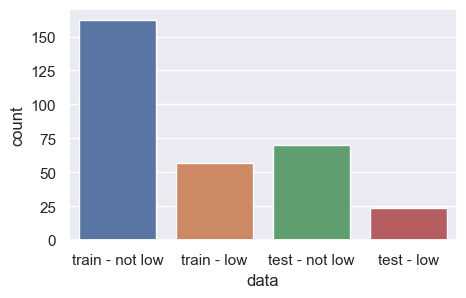

In [60]:
plot_train_test_counts(y_train, y_test)

---

## model using stratified data

### find best model for each stratified dataset 


---------------------- best stratified results for ** low_global_re **  ----------------------



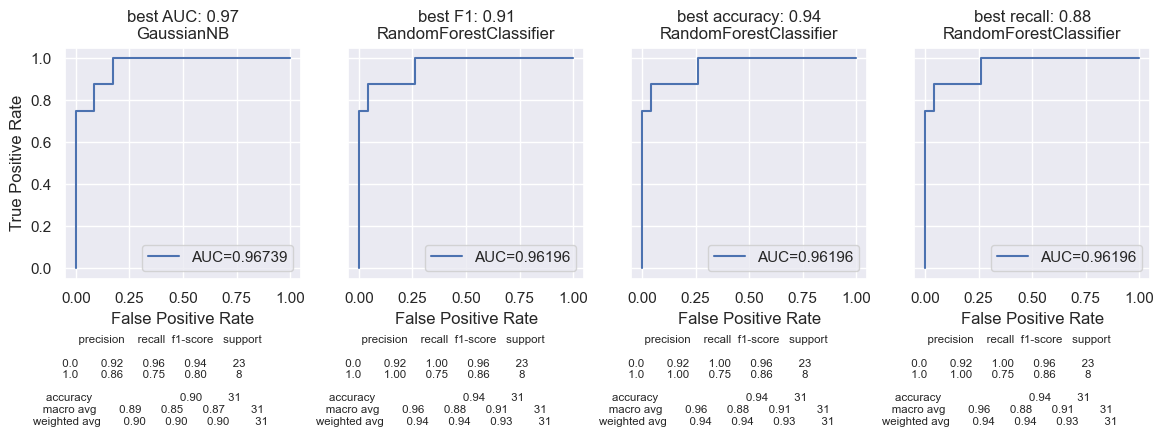


---------------------- best stratified results for ** low_cerad_re **  ----------------------



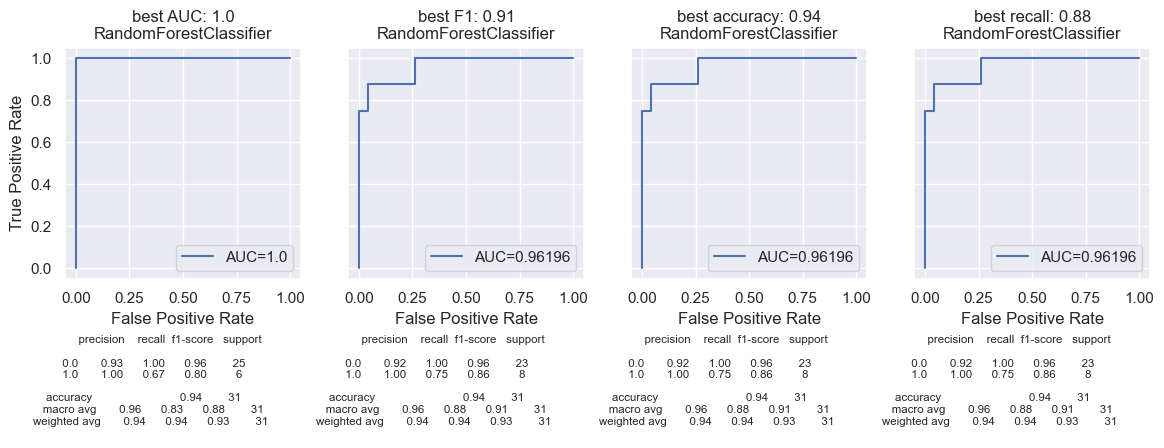


---------------------- best stratified results for ** low_animal_re **  ----------------------



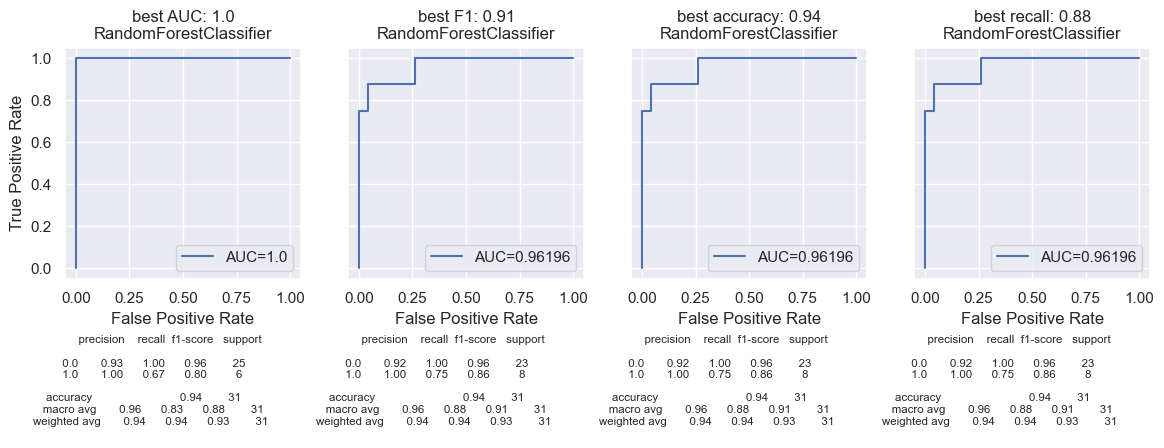


---------------------- best stratified results for ** low_digit_re **  ----------------------



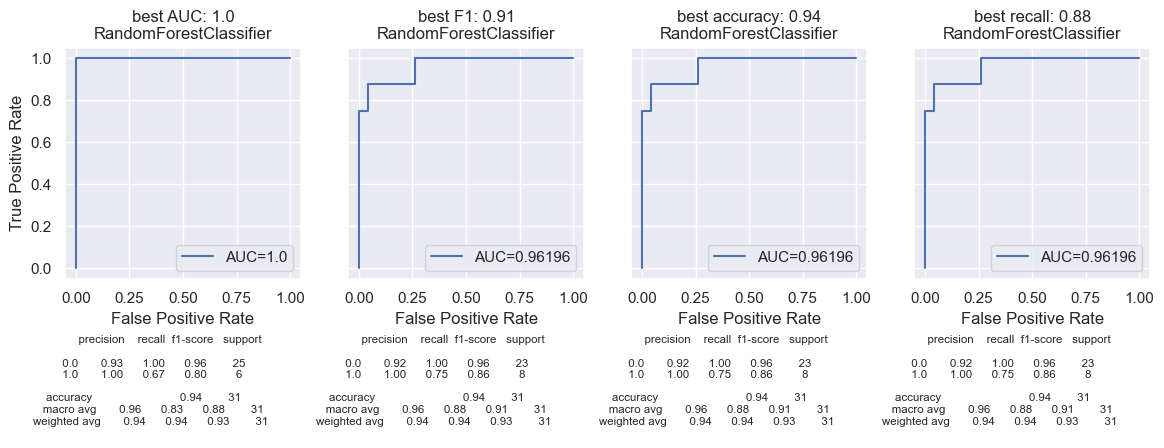


---------------------- best stratified results for ** low_delayed_re **  ----------------------



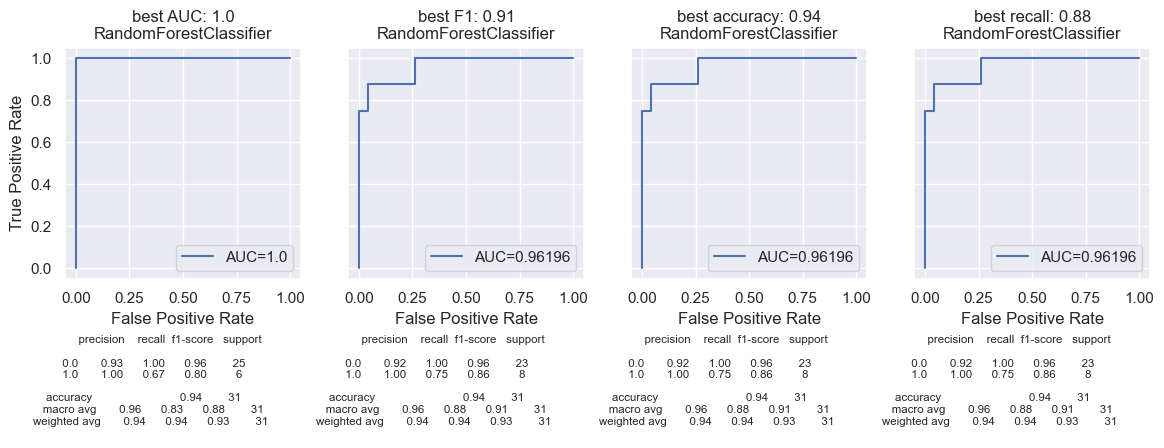

In [62]:
# skf = StratifiedKFold(n_splits=5) # no shuffling
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_auc = 0
best_f1 = 0
best_accuracy = 0
best_recall = 0

best_auc_model = None
best_model = {}
best_model['auc'] = {}
best_model['auc']['y_test'] = 0
best_model['auc']['y_pred'] = 0
best_model['auc']['y_proba'] = 0
best_model['auc']['title'] = 'best AUC'

best_f1_model = None
best_model['f1'] = {}
best_model['f1']['y_test'] = 0
best_model['f1']['y_pred'] = 0
best_model['f1']['y_proba'] = 0
best_model['f1']['title'] = 'best F1'

best_accuracy_model = None
best_model['accuracy'] = {}
best_model['accuracy']['y_test'] = 0
best_model['accuracy']['y_pred'] = 0
best_model['accuracy']['y_proba'] = 0
best_model['accuracy']['title'] = 'best accuracy'

best_recall_model = None
best_model['recall'] = {}
best_model['recall']['y_test'] = 0
best_model['recall']['y_pred'] = 0
best_model['recall']['y_proba'] = 0
best_model['recall']['title'] = 'best recall'


# reports = []
for score in scores:
    for i, (train_index, test_index) in enumerate(skf.split(train_df, y[score])):
        X_train_fold, X_test_fold = train_df.iloc[train_index], train_df.iloc[test_index]
        y_train_fold, y_test_fold = y[score][train_index], y[score][test_index]

        for model in models:
            # special case for svm.SVC
            if model == svm.SVC:
                # you can try differnt kernels for different results (e.g, 'rbr', 'linear', 'sigmoid')
                clf = svm.SVC(kernel='poly', probability=True) 
            else:
                clf = model()

            clf.fit(X_train_fold, y_train_fold)

            y_pred_fold = clf.predict(X_test_fold)
            y_proba = clf.predict_proba(X_test_fold)[::,1]

            report = classification_report(y_test_fold, y_pred_fold, zero_division=0)
            auc_score = round(roc_auc_score(y_test_fold, y_proba), 2)
            f1 = round(f1_score(y_test_fold, y_pred_fold, average='macro'), 2)
            accuracy = round(accuracy_score(y_test_fold, y_pred_fold), 2)
            recall = round(recall_score(y_test_fold, y_pred_fold, average='macro'), 2)

            model_name = str(model).split('.')[-1][:-2]
            # reports.append((f'iteration {i}: {model_name} AUC {auc_score}', report))

            if auc_score > best_auc:
                best_auc = auc_score
                best_auc_model = clf
                best_model['auc']['y_test'] = y_test_fold
                best_model['auc']['y_pred'] = y_pred_fold
                best_model['auc']['y_proba'] = y_proba
                best_model['auc']['title'] = f'best AUC: {auc_score}\n{model_name}'

            if f1 > best_f1:
                best_f1 = f1
                best_f1_model = clf
                best_model['f1']['y_test'] = y_test_fold
                best_model['f1']['y_pred'] = y_pred_fold
                best_model['f1']['y_proba'] = y_proba
                best_model['f1']['title'] = f'best F1: {f1}\n{model_name}'

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_accuracy_model = clf
                best_model['accuracy']['y_test'] = y_test_fold
                best_model['accuracy']['y_pred'] = y_pred_fold
                best_model['accuracy']['y_proba'] = y_proba
                best_model['accuracy']['title'] = f'best accuracy: {accuracy}\n{model_name}'

            if recall > best_recall:
                best_recall = recall
                best_recall_model = clf
                best_model['recall']['y_test'] = y_test_fold
                best_model['recall']['y_pred'] = y_pred_fold
                best_model['recall']['y_proba'] = y_proba
                best_model['recall']['title'] = f'best recall: {recall}\n{model_name}'
    
    print(f'\n---------------------- best stratified results for ** {score} **  ----------------------\n')
    plot_model_score_results(best_model)
    
    # plot_models = [best_auc_model, best_f1_model, best_accuracy_model, best_recall_model]
    # plot_feature_importances(train_df, plot_models)

# for name, report in reports:
#     print('\n----------------', name, '----------------\n')
#     print(report, '\n')

        